In [3]:
!gdown 1Z5kK8mo-mFX4lR4JpSS4bzV03L65cbUA
!unzip -q facemask_dataset.zip
!rm facemask_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1Z5kK8mo-mFX4lR4JpSS4bzV03L65cbUA
To: /content/facemask_dataset.zip
100% 133M/133M [00:00<00:00, 296MB/s]
replace dataset/without_mask/112.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [27]:
import os
import urllib

import matplotlib.pyplot as plt
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.applications.densenet import preprocess_input

In [25]:
img_size = 224 
batch_size = 32
classes = ["with-mask", "without-mask"]

In [7]:
directory = "dataset"

data_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Training - 80% 
train_gen = data_gen.flow_from_directory(
    directory,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

# Testing - 20% 
test_gen = data_gen.flow_from_directory(
    directory,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

Found 3067 images belonging to 2 classes.
Found 766 images belonging to 2 classes.


Found 3067 images belonging to 2 classes.


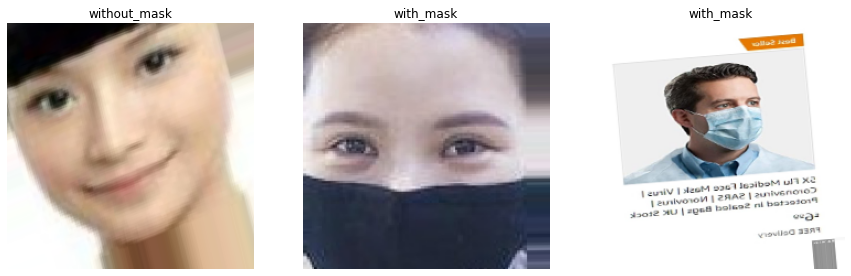

In [8]:
randomIter = data_gen.flow_from_directory(
    directory,
    target_size=(img_size,img_size),
    batch_size=1,
    class_mode='categorical',
    subset='training'
)

plt.figure(figsize=(15,10))
for i in range(3):
    randimg = next(randomIter)
    classi = list(randomIter.class_indices.keys())[list(randomIter.class_indices.values()).index(np.argmax(randimg[1]))]

    plt.subplot(1,3,i+1)
    plt.title(classi)
    plt.imshow(randimg[0].reshape(img_size, img_size, 3))
    plt.axis('off')

In [30]:
def graph_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))
    print(f"Epochs: {len(acc)}")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.plot(epochs, acc, "r", label="Training")
    ax1.plot(epochs, val_acc, "b", label="Validation")
    ax1.set_title("Training and validation accuracy")
    ax1.legend(loc=0)

    ax2.plot(epochs, loss, "r", label="Training")
    ax2.plot(epochs, val_loss, "b", label="Validation")
    ax2.set_title("Training and validation Loss")
    ax2.legend(loc=0)

    plt.show()


def confusion_matrix(data_gen):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    titles_options = [
        ("Confusion matrix, without normalization", None, ax1),
        ("Normalized confusion matrix", "true", ax2),
    ]

    y_pred = [np.argmax(prob) for prob in model.predict(data_gen)]
    y_true = data_gen.classes

    y_pred = [classes[i] for i in y_pred]
    y_true = [classes[i] for i in y_true]

    for title, normalize, axis in titles_options:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true, y_pred, cmap=plt.cm.Blues, normalize=normalize, ax=axis
        )
        disp.ax_.set_title(title)

    plt.show()


def predict_url(url):
    img = Image.open(urllib.request.urlopen(url))
    img = img.convert("RGB")
    img = img.resize((img_size, img_size))

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")

    img = preprocess_input(np.array(img))
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:4]:
        print(f"Type {classes[idx]}: \t{round(probs[0][idx]*100,2)}%")


def predict_urls(*urls):
    num = len(urls)
    threshold = 2 if num <= 4 else 3
    x_align = max(int(num ** 0.5), threshold)
    y_align = max(num - x_align, threshold)

    plt.figure(figsize=(x_align * 3, y_align * 3))
    for idx, url in enumerate(urls):
        plt.subplot(y_align, x_align, idx + 1)

        img = Image.open(urllib.request.urlopen(url))
        img = img.convert("RGB")
        img = img.resize((img_size, img_size))

        pre_img = preprocess_input(np.array(img))
        probs = model.predict(np.expand_dims(pre_img, axis=0))

        tittle = [
            f"Type {classes[idx]} ({round(probs[0][idx]*100,2)}%)\n"
            for idx in probs.argsort()[0][::-1][:3]
        ]
        plt.title("".join(tittle))

        plt.axis("off")
        plt.imshow(img)

    plt.tight_layout()
    plt.show()


In [19]:
inputs = keras.Input(shape=(img_size, img_size, 3))

mobilenet = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=keras.layers.Input(shape=(img_size, img_size, 3)))

x = mobilenet(inputs)
x = keras.layers.AveragePooling2D(pool_size=(7, 7))(x)
x = keras.layers.Flatten(name="flatten")(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs, outputs)

for layer in mobilenet.layers:
  layer.trainable = False

optimizer = keras.optimizers.Adam(
    learning_rate=0.0001,
    decay=0.0001/20
)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_5 (Averag  (None, 1, 1, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               163968    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0   

In [20]:
os.mkdir('training')
checkpoint_path = "training/cp-{epoch:04d}.ckpt" #"training/cp-best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    verbose=0,
    save_weights_only = True,
    save_freq = 64
)

In [21]:
history = model.fit(
    train_gen,
    steps_per_epoch=3067//32, #len(training) // batchsize
    epochs=20,
    verbose=1,
    validation_data=test_gen,
    validation_steps=766//32, #len(test) // batchsize
    callbacks=[cp_callback]
)

Epoch 1/20
62/95 [==================>...........] - ETA: 15s - loss: 0.5808 - accuracy: 0.7505

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


95/95 [==============================] - 59s 593ms/step - loss: 0.4866 - accuracy: 0.8129 - val_loss: 0.2058 - val_accuracy: 0.9674
Epoch 2/20
95/95 [==============================] - 55s 582ms/step - loss: 0.2010 - accuracy: 0.9489 - val_loss: 0.1109 - val_accuracy: 0.9728
Epoch 3/20
95/95 [==============================] - 60s 632ms/step - loss: 0.1252 - accuracy: 0.9690 - val_loss: 0.0826 - val_accuracy: 0.9796
Epoch 4/20
95/95 [==============================] - 60s 628ms/step - loss: 0.1031 - accuracy: 0.9707 - val_loss: 0.0706 - val_accuracy: 0.9796
Epoch 5/20
95/95 [==============================] - 58s 610ms/step - loss: 0.0849 - accuracy: 0.9779 - val_loss: 0.0724 - val_accuracy: 0.9755
Epoch 6/20
95/95 [==============================] - 61s 643ms/step - loss: 0.0691 - accuracy: 0.9799 - val_loss: 0.0605 - val_accuracy: 0.9783
Epoch 7/20
95/95 [==============================] - 63s 662ms/step - loss: 0.0733 - accuracy: 0.9766 - val_loss: 0.0563 - val_accuracy: 0.9837
Epoch 8/20

In [34]:
model.save("model/facemasks.model", save_format="h5")

Epochs: 20


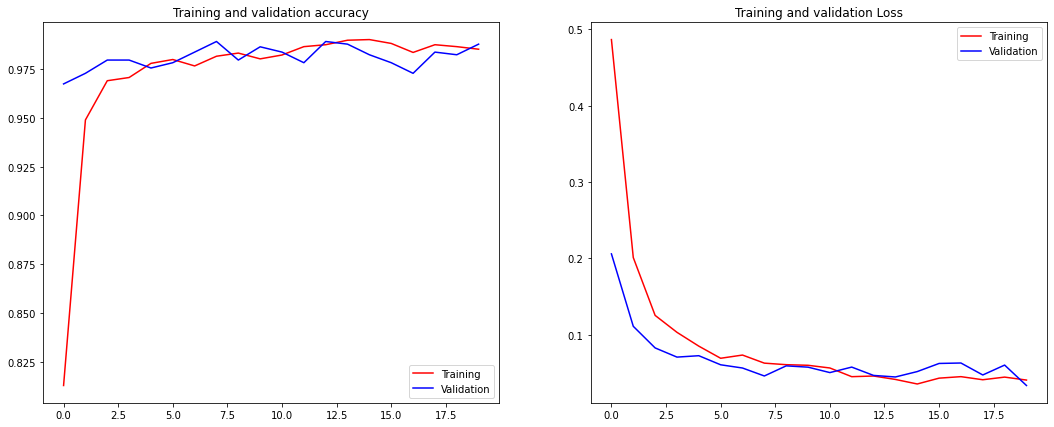

In [23]:
graph_history(history)

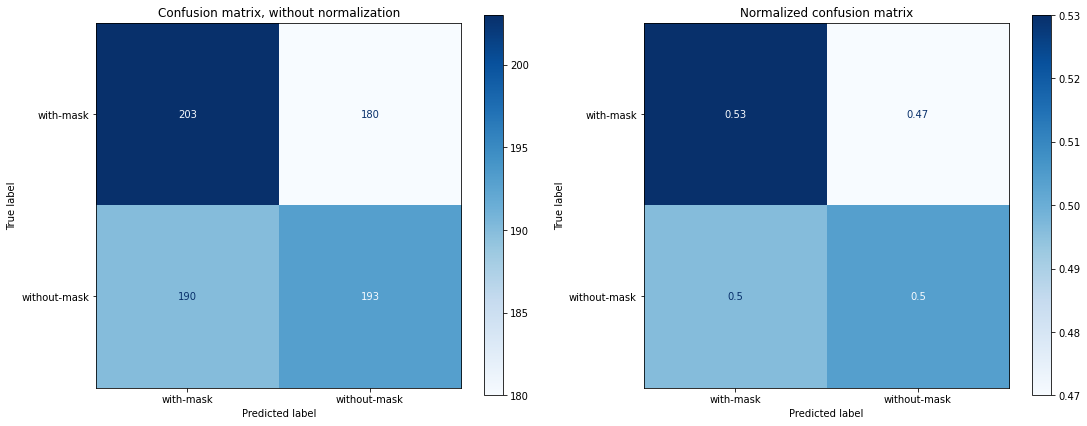

In [28]:
confusion_matrix(test_gen)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


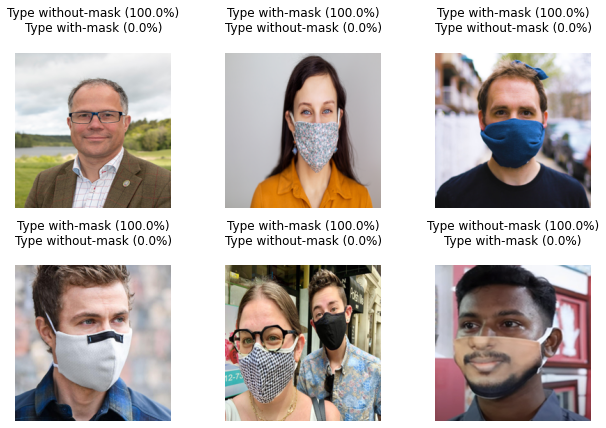

In [35]:
predict_urls(
    "https://www.face.eu/wp-content/uploads/2018/09/Torbjorn-Larsson.jpg",
    "https://images.theconversation.com/files/336067/original/file-20200519-152327-1dts6e7.jpg",
    "https://static01.nyt.com/images/2020/04/10/video/HowToMakeAMask_Cover_1/HowToMakeAMask_Cover_1-square640.jpg",
    "https://specials-images.forbesimg.com/imageserve/5f24a25bf9c9ba4b7acb1896/960x0.jpg",
    "https://i.insider.com/5f1b5a112618b95bcc640b96",
    "https://i.imgur.com/JeNcinN.png",
)